In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
np.random.seed(12)

# asset = np.random.normal(mean, std, size)
asset_a = np.random.normal(0.001, 0.02, 252)
asset_b = np.random.normal(0.0008, 0.015, 252)
asset_c = np.random.normal(0.0012, 0.025, 252)

returns = pd.DataFrame({
    "assetA" : asset_a,
    "assetB" : asset_b,
    "assetC" : asset_c
})

volatility = returns.std()

inv_vol = 1 / volatility
weights = inv_vol / inv_vol.sum()

portfolio_return = np.dot(weights, returns.mean())
portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))

equal_w = np.ones(len(returns.columns)) / len(returns.columns)

equal_w_return = np.dot(equal_w, returns.mean())
equal_w_vol = np.sqrt(np.dot(equal_w.T, np.dot(returns.cov(), equal_w)))


print(f"Inverse Vol Weights {weights}, EqualVol {equal_w_vol}, Inverse Vol {portfolio_vol}")


Inverse Vol Weights assetA    0.301811
assetB    0.444832
assetC    0.253357
dtype: float64, EqualVol 0.011026286952290826, Inverse Vol 0.0101824772114946


          assetA    assetB    assetC
assetA  1.000000 -0.087151 -0.110364
assetB -0.087151  1.000000 -0.019527
assetC -0.110364 -0.019527  1.000000


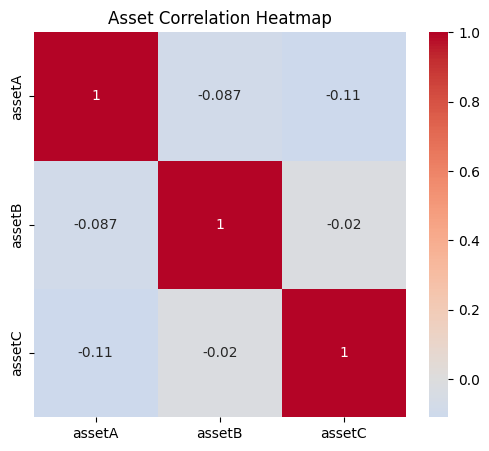

In [20]:
corr = returns.corr()
print(corr)

import seaborn as sns
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Asset Correlation Heatmap")
plt.show()

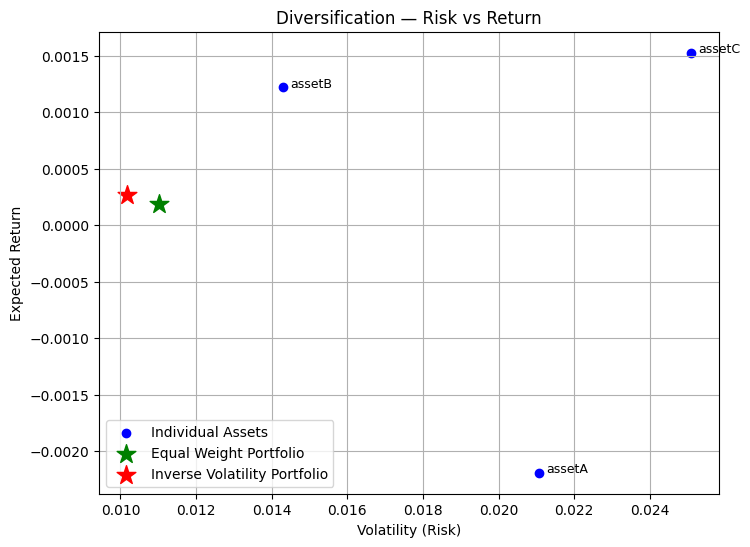

In [22]:
mean_returns = returns.mean()
volatilities = returns.std()

plt.figure(figsize=(8,6))

plt.scatter(volatilities, mean_returns, color='blue', label='Individual Assets')
for i, asset in enumerate(returns.columns):
  plt.text(volatilities.iloc[i]+0.0002, mean_returns.iloc[i], asset, fontsize=9)


plt.scatter(equal_w_vol, equal_w_return, color='green', marker='*', s=200, label='Equal Weight Portfolio')
plt.scatter(portfolio_vol, portfolio_return, color='red', marker='*', s=200, label='Inverse Volatility Portfolio')

plt.xlabel("Volatility (Risk)")
plt.ylabel("Expected Return")
plt.title("Diversification — Risk vs Return")
plt.legend()
plt.grid(True)
plt.show()


Optimal Weights:
assetA: 0.000
assetB: 0.701
assetC: 0.299

Expected Return: 0.0013
Volatility: 0.0124
Sharpe Ratio: 0.0898


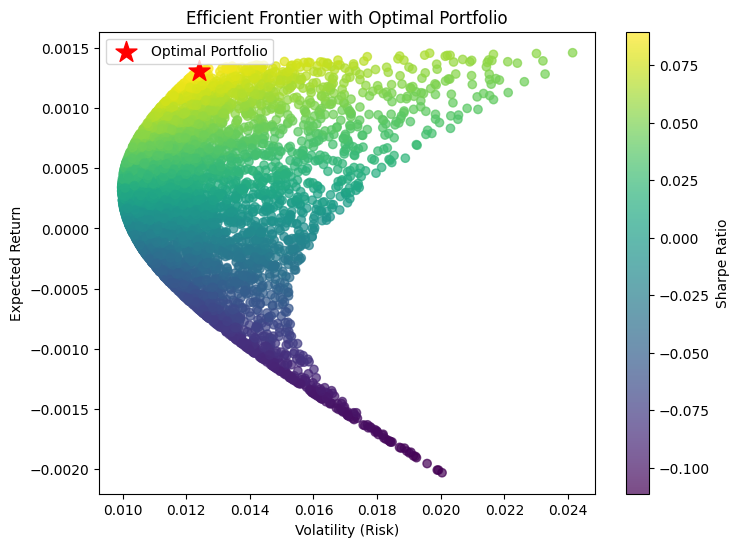

In [23]:
from scipy.optimize import minimize

# --- Step 1: Setup ---
mean_returns = returns.mean()
cov_matrix = returns.cov()
Rf = 0.0002

# --- Step 2: Portfolio stats ---
def portfolio_stats(weights):
    port_return = np.dot(weights, mean_returns)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (port_return - Rf) / port_vol
    return port_return, port_vol, sharpe

# --- Step 3: Objective (negative Sharpe) ---
def neg_sharpe(weights):
    return -portfolio_stats(weights)[2]

# --- Step 4: Optimization setup ---
num_assets = len(mean_returns)
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
bounds = tuple((0, 1) for _ in range(num_assets))
initial_guess = np.ones(num_assets) / num_assets

opt_result = minimize(neg_sharpe, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints)

# --- Step 5: Extract results ---
opt_weights = opt_result.x
opt_return, opt_vol, opt_sharpe = portfolio_stats(opt_weights)

print("Optimal Weights:")
for asset, weight in zip(returns.columns, opt_weights):
    print(f"{asset}: {weight:.3f}")

print(f"\nExpected Return: {opt_return:.4f}")
print(f"Volatility: {opt_vol:.4f}")
print(f"Sharpe Ratio: {opt_sharpe:.4f}")

# --- Optional: Plot Efficient Frontier + Optimal Point ---
portfolio_returns = []
portfolio_vols = []
for _ in range(5000):
    w = np.random.random(num_assets)
    w /= np.sum(w)
    r, v, _ = portfolio_stats(w)
    portfolio_returns.append(r)
    portfolio_vols.append(v)

plt.figure(figsize=(8,6))
plt.scatter(portfolio_vols, portfolio_returns, c=(np.array(portfolio_returns)-Rf)/np.array(portfolio_vols), cmap='viridis', alpha=0.7)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(opt_vol, opt_return, color='red', marker='*', s=250, label='Optimal Portfolio')
plt.title("Efficient Frontier with Optimal Portfolio")
plt.xlabel("Volatility (Risk)")
plt.ylabel("Expected Return")
plt.legend()
plt.show()



Risk Contribution (%):
assetA: 31.27%
assetB: 34.81%
assetC: 33.91%


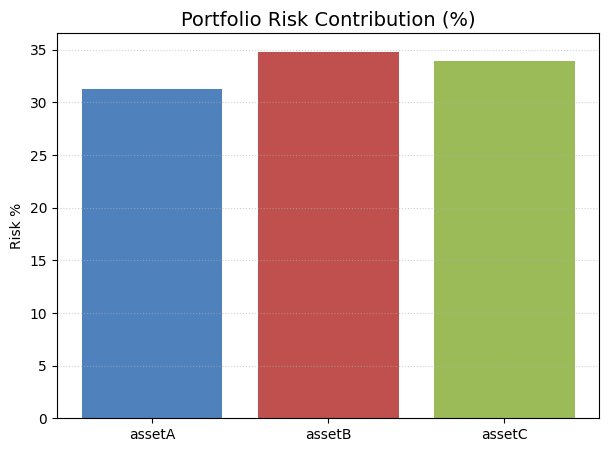

In [25]:
# --- Covariance matrix ---
cov_matrix = returns.cov()

# --- Portfolio volatility ---
portfolio_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# --- Marginal contribution to risk ---
marginal_contrib = np.dot(cov_matrix, weights)

# --- Risk contribution per asset ---
risk_contrib = (weights * marginal_contrib) / portfolio_vol
risk_contrib_percent = 100 * risk_contrib / risk_contrib.sum()

# --- Print results ---
print("Risk Contribution (%):")
for asset, rc in zip(returns.columns, risk_contrib_percent):
    print(f"{asset}: {rc:.2f}%")

# --- Plot ---
plt.figure(figsize=(7,5))
plt.bar(returns.columns, risk_contrib_percent, color=["#4F81BD","#C0504D","#9BBB59"])
plt.title("Portfolio Risk Contribution (%)", fontsize=14)
plt.ylabel("Risk %")
plt.grid(axis="y", linestyle=":", alpha=0.6)
plt.show()

